In [ ]:
!pip install pandas
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score


# Load Dataset
Inisialisasi variable, masukan NIM di sini untuk random state.

Random state digunakan untuk training & validation split.

In [ ]:
filepath = "./seeds_dataset.txt"

# Isi nim anda di sini
nim = 1304202025

Load dataset, cek konten data

Target kelas: **Category**

In [ ]:
df = pd.read_csv(filepath, sep="\t")
df.sample(10, random_state=nim)

,Area,Perimeter,Compactness,Kernel_len,Kernel_width,Assymetry,Groove_len,Category
119,20.03,16.90,0.8811,6.493,3.857,3.063,6.320,2
65,12.88,13.50,0.8879,5.139,3.119,2.352,4.607,1
117,19.15,16.45,0.8890,6.245,3.815,3.084,6.185,2
131,18.94,16.32,0.8942,6.144,3.825,2.908,5.949,2
112,19.13,16.31,0.9035,6.183,3.902,2.109,5.924,2
171,11.55,13.10,0.8455,5.167,2.845,6.715,4.956,3
141,13.32,13.94,0.8613,5.541,3.073,7.035,5.440,3
134,15.56,14.89,0.8823,5.776,3.408,4.972,5.847,2
198,12.62,13.67,0.8481,5.410,2.911,3.306,5.231,3
149,10.79,12.93,0.8107,5.317,2.648,5.462,5.194,3


Training/test split **60/40**

In [ ]:
# X: semua kolom, Y: kolom terakhir (category)
x = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=nim)

len(x_train), len(x_test)

# We perform bootstrap on the train data
# Keep test data for final accuracy testing

(126, 84)

# Random Forest
Build 20 Decision Tree classifer, dengan tahapan:

1. Siapkan Bootstrap data (pilih secara acak dari training data, sampling with replacement)
2. Pilih 2-4 random features secara acak
3. Build Decision Tree classifier menggunakan (1) dan (2)
4. Calculate OOB error within the tree only

**NOTE**
This whole exercise has been simplified.
- Tree is created automatically, therefore you cannot control the feature selection on node level
- Random features are only selected in the beginning of each tree, instead of at every node
split
- OOB error is only calculated within its own tree instead of on the whole forest
- Typically Random Forest don't use train/test split and can be validated using OOB error. We simplify this to make it easier to test.


In [ ]:
np.random.seed(nim)
n_tree = 20

forest = []
bootstrap_columns = []
average = 0
for i in range(n_tree):
    # 1. Bootstrapping
    # select random rows
    rows = np.random.choice(range(len(x_train)), size=len(x_train), replace=True)
    x_bootstrap = x_train.iloc[rows, :]
    y_bootstrap = y_train.iloc[rows]

    # Out of Bag data
    non_selected_rows = list(set(range(len(x_train))) - set(rows))
    x_oob = x_train.iloc[non_selected_rows, :]
    y_oob = y_train.iloc[non_selected_rows]

    # 2. Select random features (make sure to keep track the selected columns)
    # Check for any repeated combinations
    feature_taken = np.random.randint(2, 4)
    cols = np.random.choice(x_train.columns, size=feature_taken, replace=False)
    bootstrap_columns.append(cols)

    # filter based on the selected columns
    x_bootstrap = x_bootstrap.loc[:, cols]

    # 3. Build decision tree
    # Let it grow, no pruning, no max depth
    tree_model = tree.DecisionTreeClassifier(criterion="entropy")
    tree_model = tree_model.fit(x_bootstrap, y_bootstrap)

    # Add it to the forest
    forest.append(tree_model)

    # 4. Calculate oob error only within its own tree
    x_oob = x_oob.loc[:, cols]
    y_pred_oob = tree_model.predict(x_oob)
    oob_error = (y_pred_oob != y_oob).mean()
    average += oob_error
    print(f"Tree {i+1}: OOB Error - {oob_error:.2f}")

average_oob_error = average/20
print(f"Average OOB Error : {average_oob_error:.2f}")


Tree 1: OOB Error - 0.22
Tree 2: OOB Error - 0.21
Tree 3: OOB Error - 0.20
Tree 4: OOB Error - 0.24
Tree 5: OOB Error - 0.20
Tree 6: OOB Error - 0.24
Tree 7: OOB Error - 0.21
Tree 8: OOB Error - 0.18
Tree 9: OOB Error - 0.15
Tree 10: OOB Error - 0.11
Tree 11: OOB Error - 0.34
Tree 12: OOB Error - 0.11
Tree 13: OOB Error - 0.11
Tree 14: OOB Error - 0.17
Tree 15: OOB Error - 0.08
Tree 16: OOB Error - 0.16
Tree 17: OOB Error - 0.11
Tree 18: OOB Error - 0.14
Tree 19: OOB Error - 0.17
Tree 20: OOB Error - 0.12
Average OOB Error : 0.17


# Prediction and Voting
Run prediction on x_test data for each tree

Also calculate accuracy per tree here

In [ ]:
all_preds = []
for i, tree_model in enumerate(forest):
    # Each tree has different column requirements
    # Make sure you use the correct columns for each tree
    x_test_filtered = x_test.loc[:, bootstrap_columns[i]]

    predictions = tree_model.predict(x_test_filtered)

    # Might as well calculate accuracy per tree here...

    acc = accuracy_score(y_test, predictions)

    # add it to all_preds for voting later
    all_preds.append(predictions)

    print(f"Tree ke-{i+1}: Accuracy - {acc:.2f}")


all_preds = np.array(all_preds)

Tree ke-1: Accuracy - 0.85
Tree ke-2: Accuracy - 0.81
Tree ke-3: Accuracy - 0.81
Tree ke-4: Accuracy - 0.68
Tree ke-5: Accuracy - 0.79
Tree ke-6: Accuracy - 0.81
Tree ke-7: Accuracy - 0.87
Tree ke-8: Accuracy - 0.85
Tree ke-9: Accuracy - 0.76
Tree ke-10: Accuracy - 0.92
Tree ke-11: Accuracy - 0.85
Tree ke-12: Accuracy - 0.86
Tree ke-13: Accuracy - 0.93
Tree ke-14: Accuracy - 0.83
Tree ke-15: Accuracy - 0.89
Tree ke-16: Accuracy - 0.81
Tree ke-17: Accuracy - 0.92
Tree ke-18: Accuracy - 0.92
Tree ke-19: Accuracy - 0.81
Tree ke-20: Accuracy - 0.83


### Perform voting on the predictions from the Random Forest

In [ ]:
# Insert voting code here
# ...
# ...
#
from collections import Counter
voted_predictions = np.array([Counter(column).most_common(1)[0][0] for column in all_preds.T])


# Calculate accuracy of Test data on the Forest
correct = voted_predictions == y_test
acc = np.sum(correct) / len(y_test)
print(f"Accuracy of the Random Forest: {acc}")



Accuracy of the Random Forest: 0.8452380952380952


In [ ]:
for i, cols in enumerate(bootstrap_columns):
    print(f"Tree {i+1}: Selected Columns - {cols}")

Tree 1: Selected Columns - ['Perimeter' 'Assymetry']
Tree 2: Selected Columns - ['Perimeter' 'Compactness' 'Kernel_len']
Tree 3: Selected Columns - ['Area' 'Perimeter' 'Kernel_len']
Tree 4: Selected Columns - ['Kernel_width' 'Assymetry']
Tree 5: Selected Columns - ['Perimeter' 'Kernel_width' 'Kernel_len']
Tree 6: Selected Columns - ['Kernel_width' 'Compactness' 'Perimeter']
Tree 7: Selected Columns - ['Groove_len' 'Kernel_width']
Tree 8: Selected Columns - ['Kernel_len' 'Assymetry' 'Area']
Tree 9: Selected Columns - ['Assymetry' 'Compactness' 'Kernel_width']
Tree 10: Selected Columns - ['Kernel_len' 'Groove_len' 'Kernel_width']
Tree 11: Selected Columns - ['Area' 'Compactness']
Tree 12: Selected Columns - ['Perimeter' 'Compactness']
Tree 13: Selected Columns - ['Groove_len' 'Area' 'Assymetry']
Tree 14: Selected Columns - ['Area' 'Compactness' 'Assymetry']
Tree 15: Selected Columns - ['Area' 'Assymetry' 'Kernel_width']
Tree 16: Selected Columns - ['Compactness' 'Area']
Tree 17: Selected

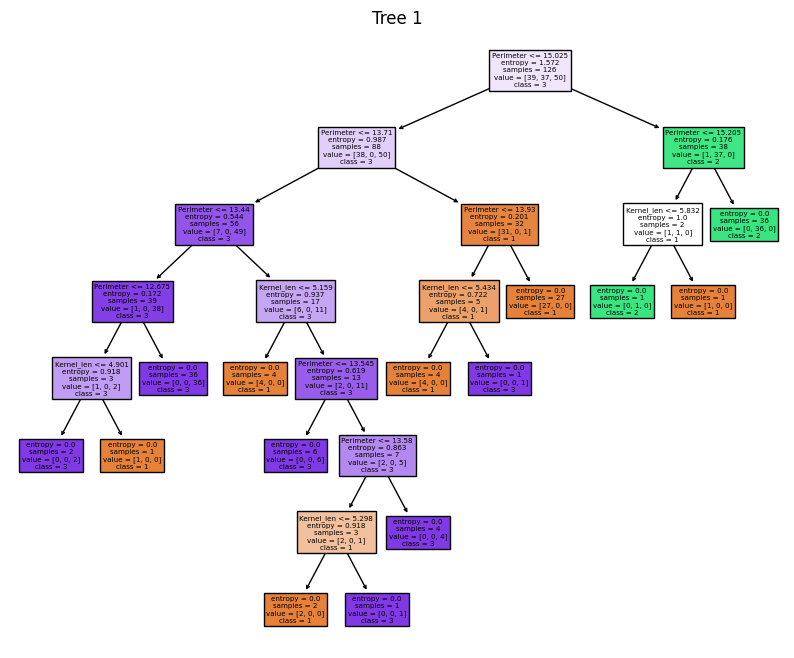

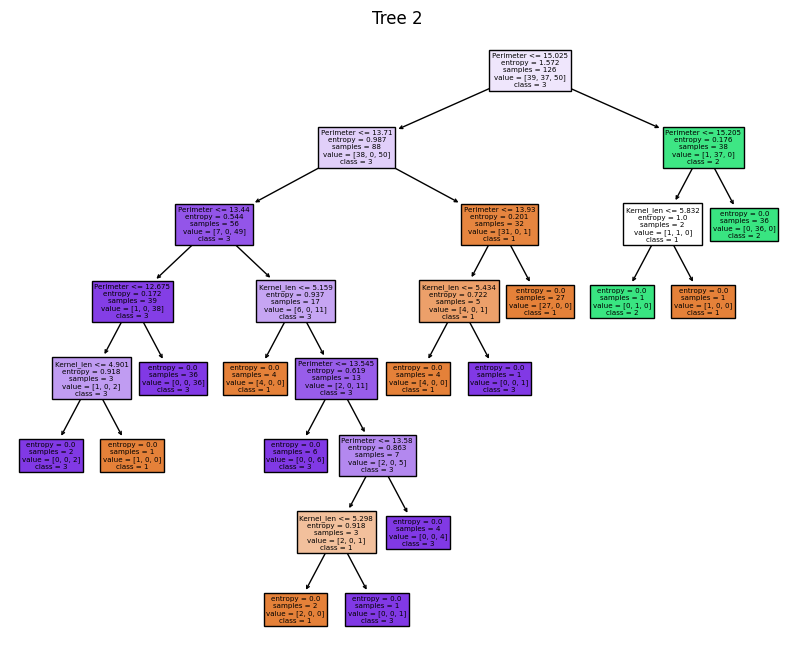

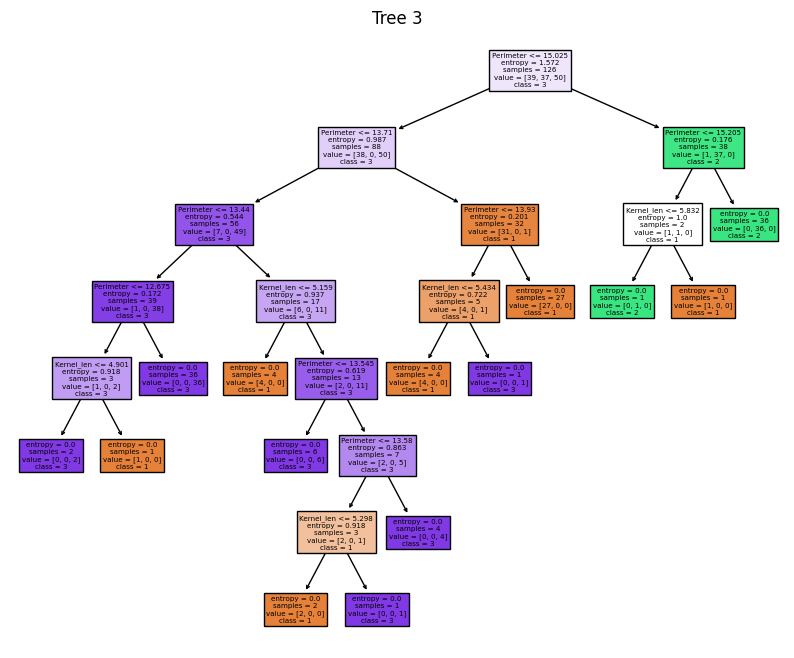

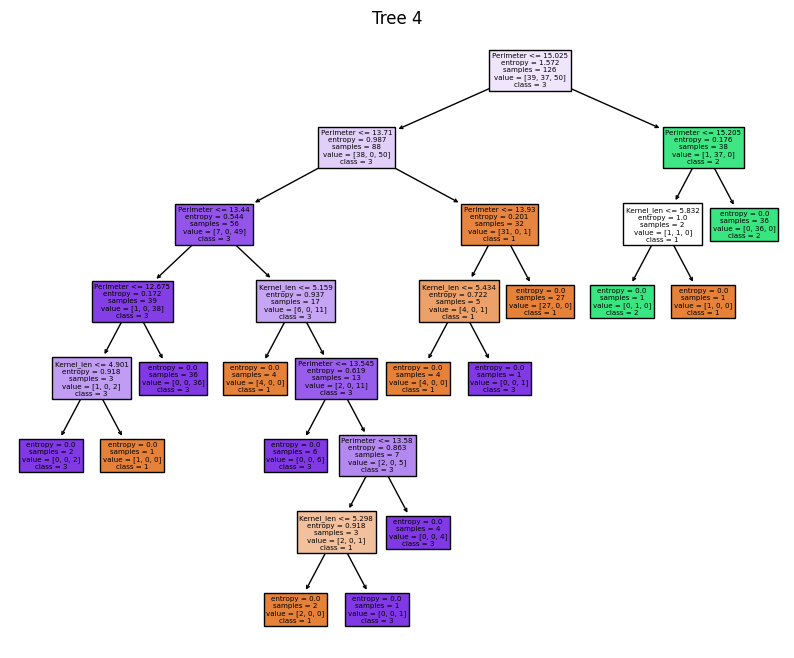

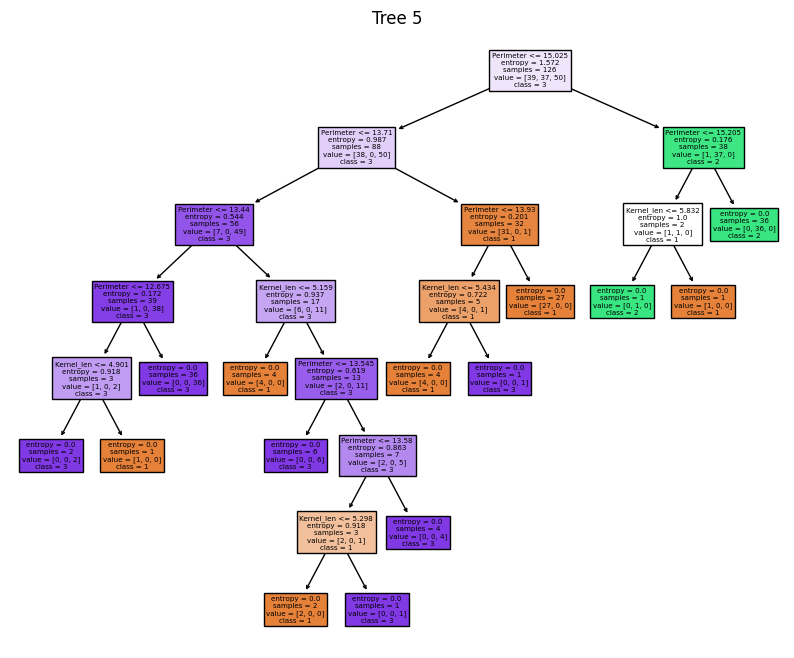

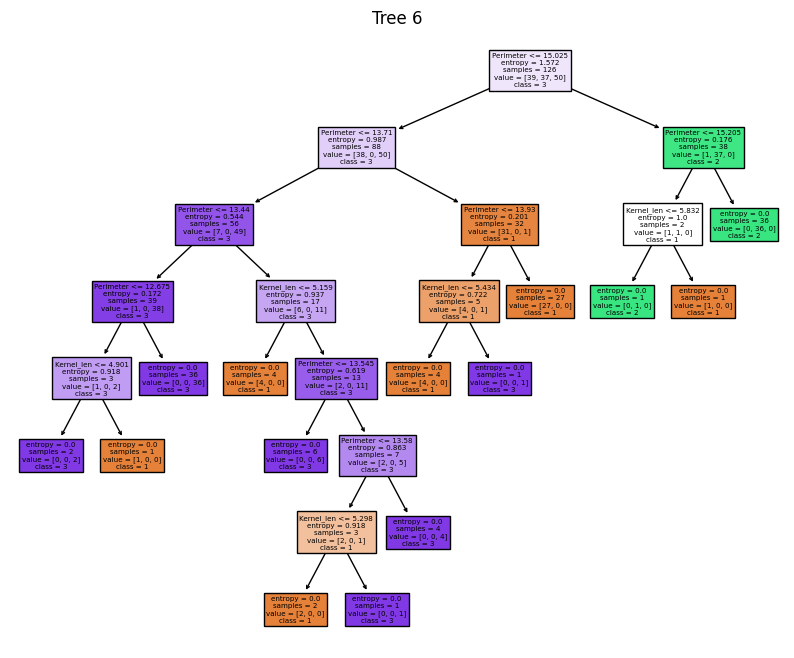

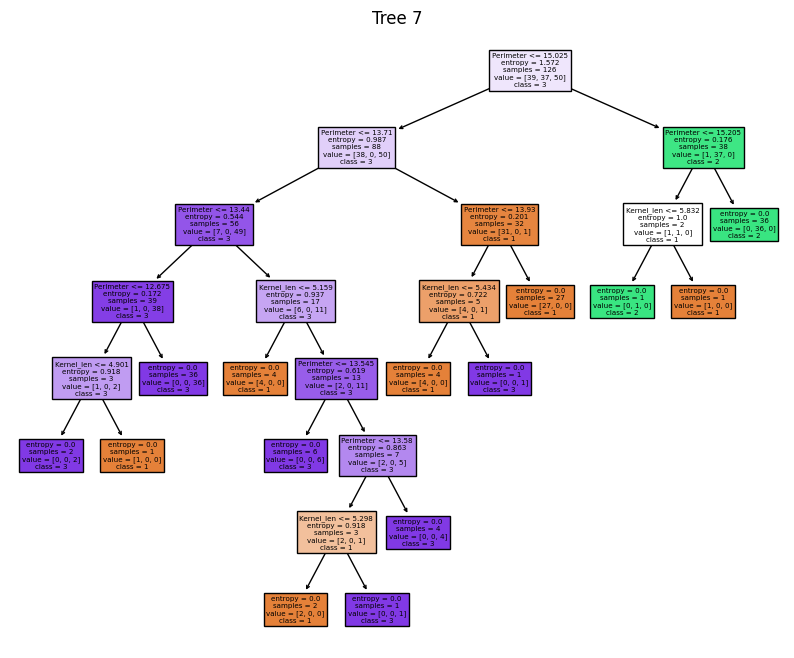

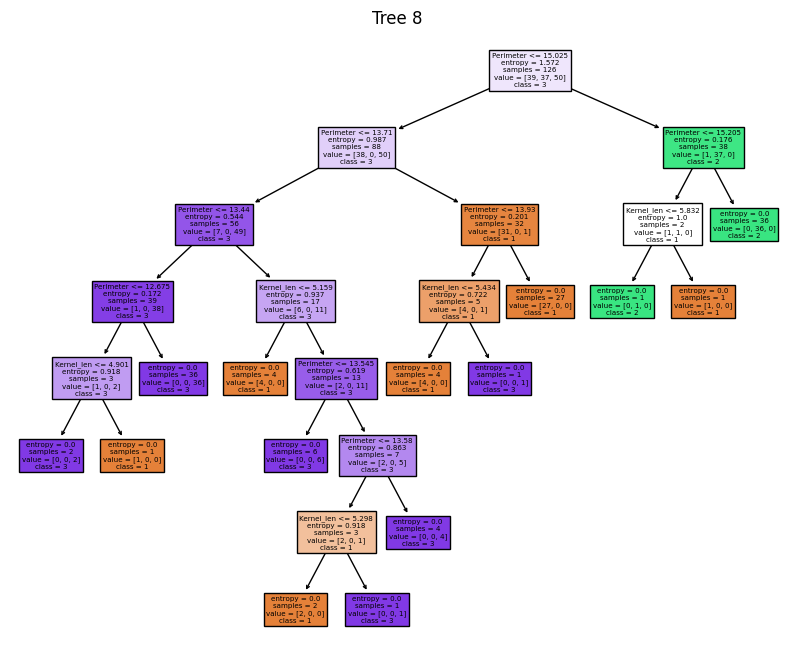

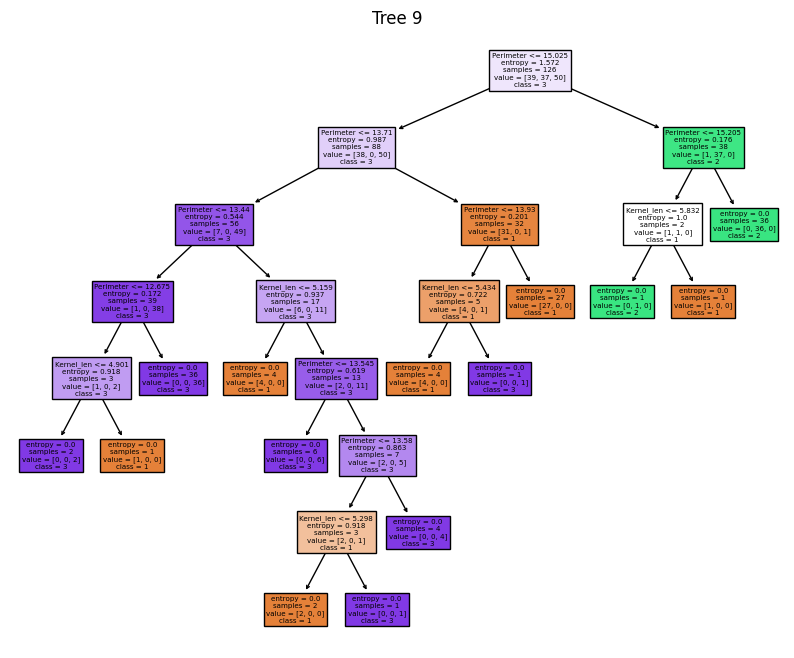

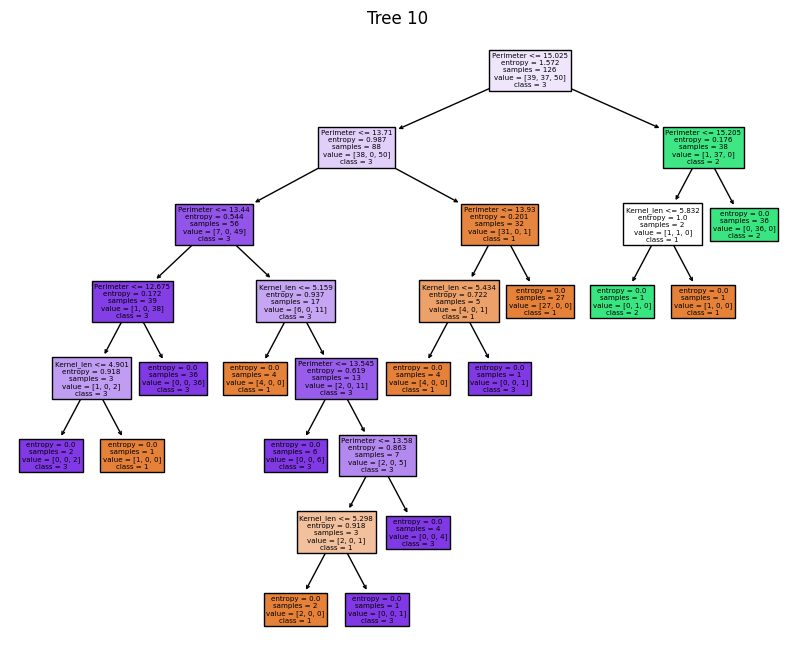

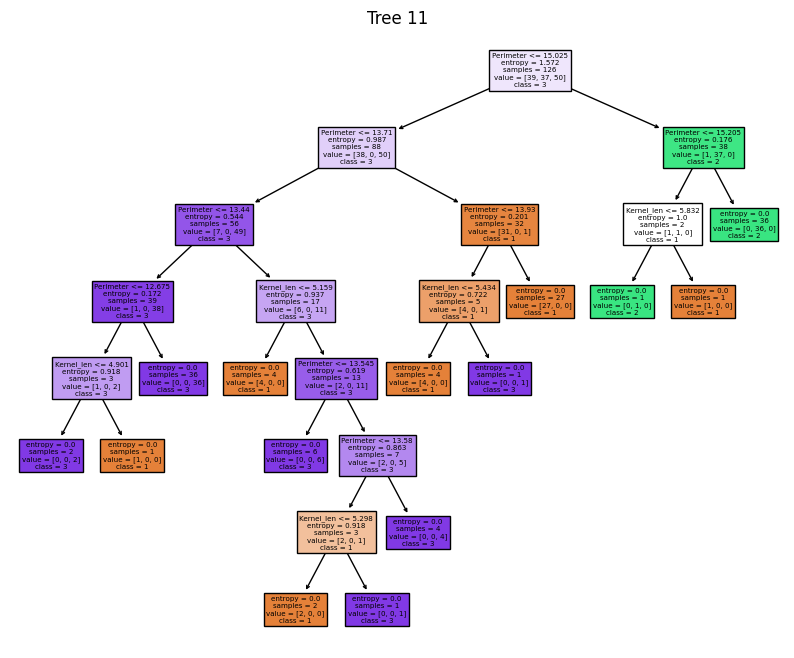

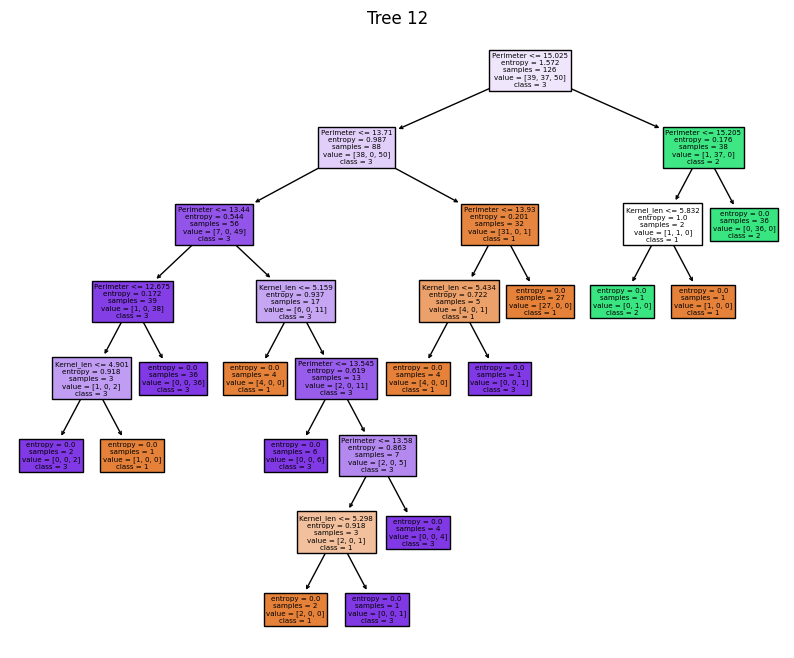

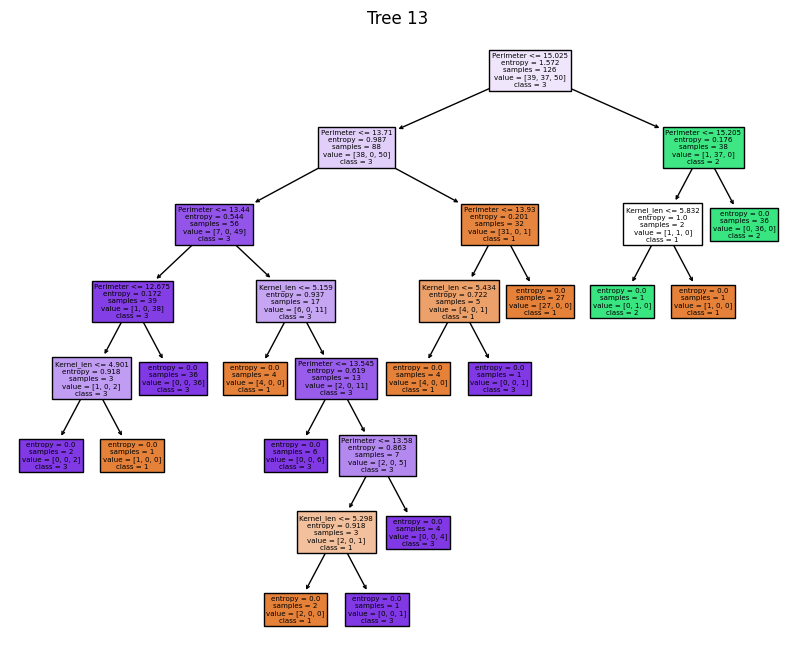

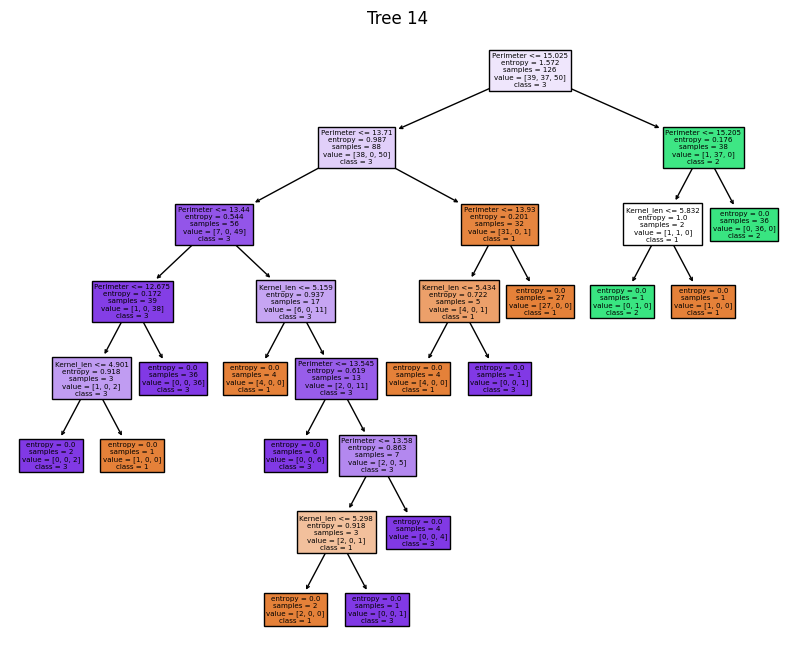

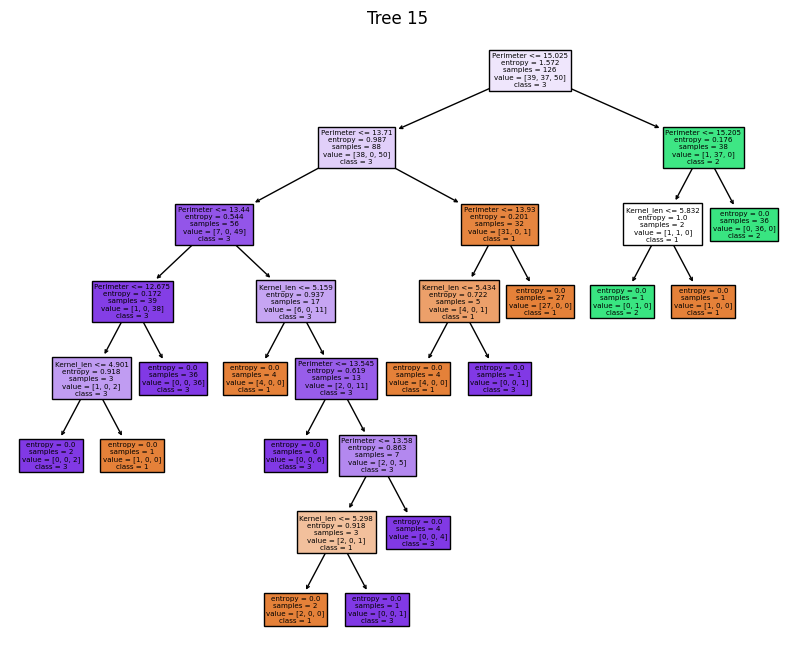

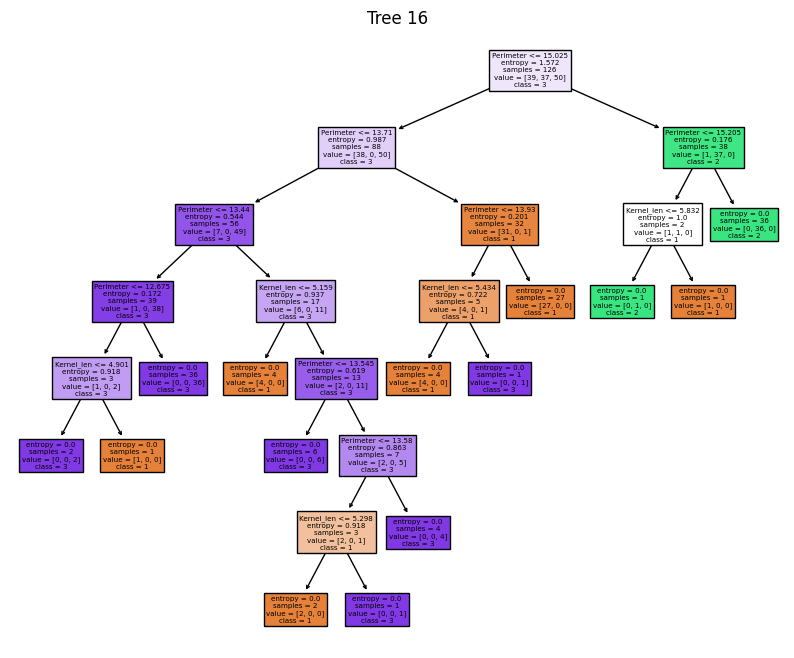

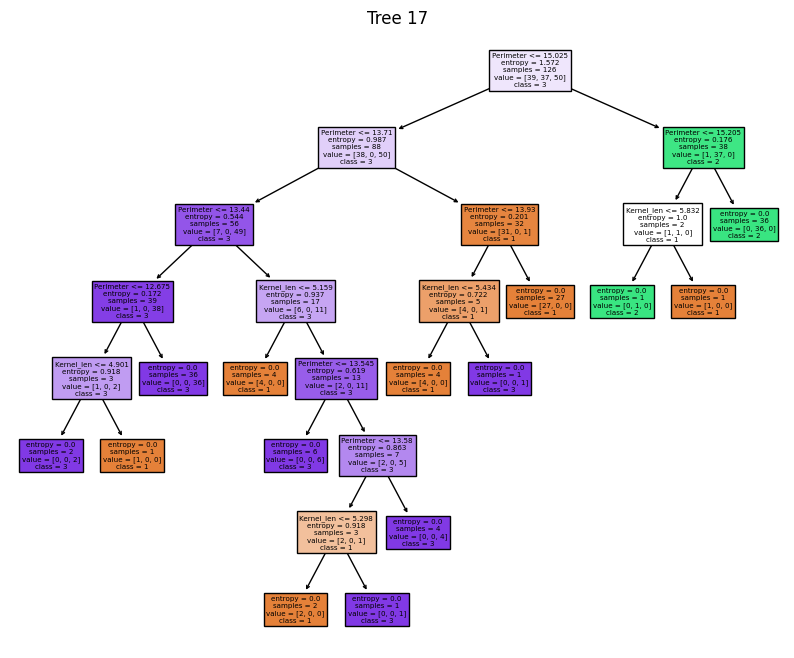

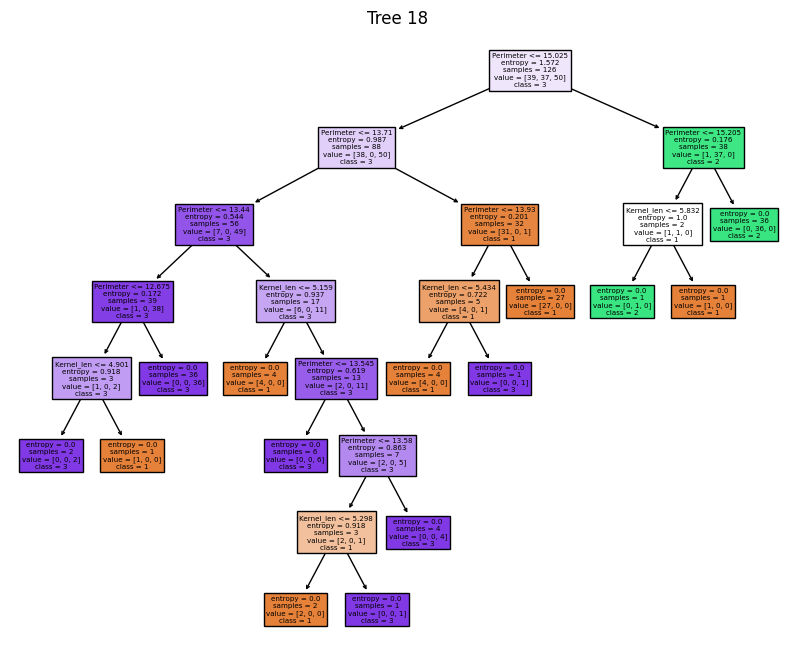

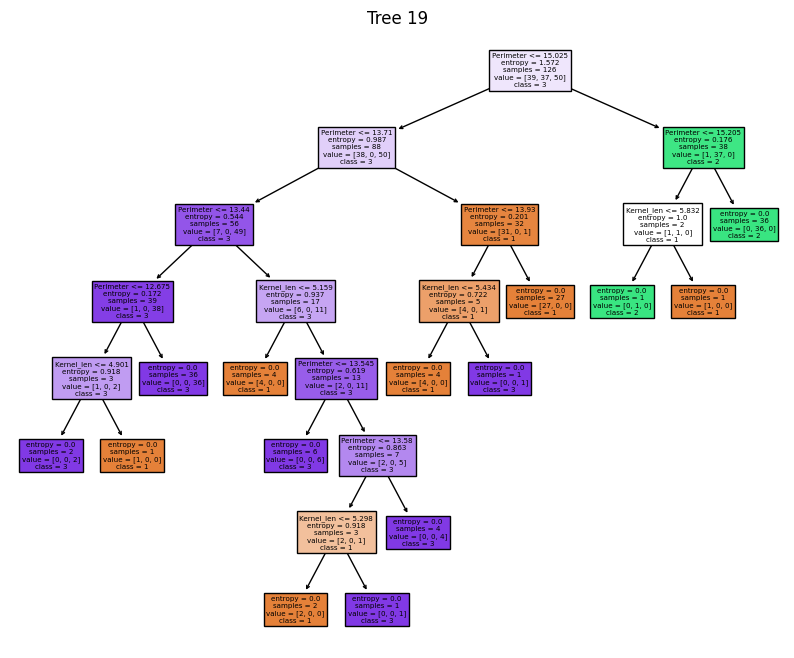

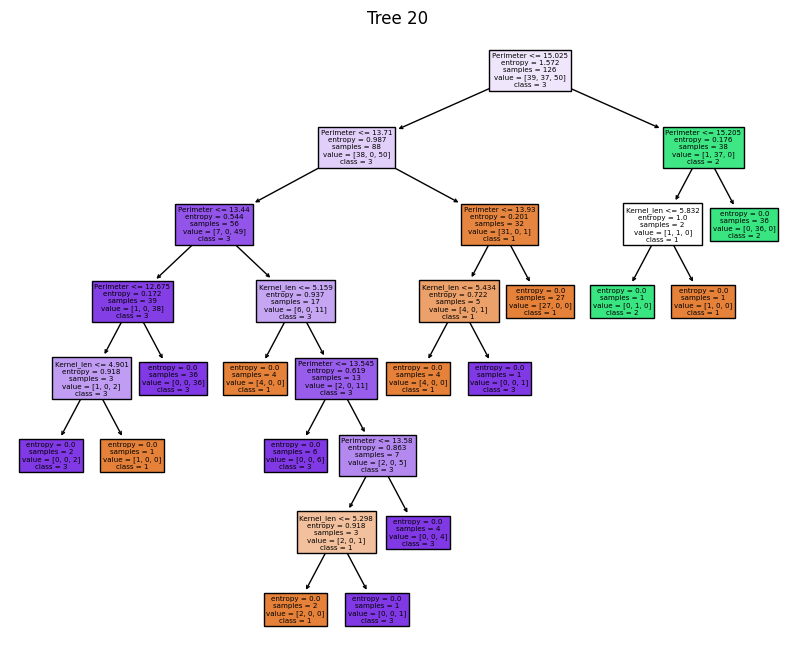

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
for i in range(n_tree):

    plt.figure(figsize=(10, 8))
    plot_tree(tree_model, filled=True, feature_names=cols, class_names=[str(c) for c in tree_model.classes_])
    plt.title(f'Tree {i+1}')
    plt.show()